#### 4.1 なぜ特徴量と予測値の関係を知る必要があるのか？

- Partial Dependence: 特徴量と予測値の関係を解釈するための手法、線形か非線形かなどを判断する。
  - ある特徴量が大きくなると、それに伴って予測値はどう変化するかなど

In [2]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any
from __future__ import annotations

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import japanize_matplotlib

sys.path.append("..")
from mli.visualize import get_visualization_setting



In [ ]:
np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")

##### 4.2.1 シミュレーション1：線形の場合

シミュレーションの設定は以下の通り

$$
Y = X + \varepsilon\\
X \sim Uniform(0,1)\\
\varepsilon \sim Normal(0, 0.01)
$$

In [6]:
from sklearn.model_selection import train_test_split

def generate_simulation_data1():
    """シミュレーション1のデータを生成"""

    N = 1000
    beta = np.array([1])

    X = np.random.uniform(0,1,[N,1])
    epsilon = np.random.normal(0, 0.1, N)
    y = X @ beta + epsilon

    return train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_test, y_train, y_test = generate_simulation_data1()

In [18]:
def plot_scatter(x, y, xlabel = "X", ylabel = "Y", title = None):
    """散布図を作成"""

    fig, ax = plt.subplots()
    sns.scatterplot(x = x, y = y, alpha = 0.3, ax = ax)
    ax.set(xlabel = xlabel, ylabel = ylabel)
    fig.suptitle(title)
    fig.show()
    

/var/folders/2b/gxdp9fvj60s6j5jv0wtqz9br0000gn/T/ipykernel_62980/3246857971.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


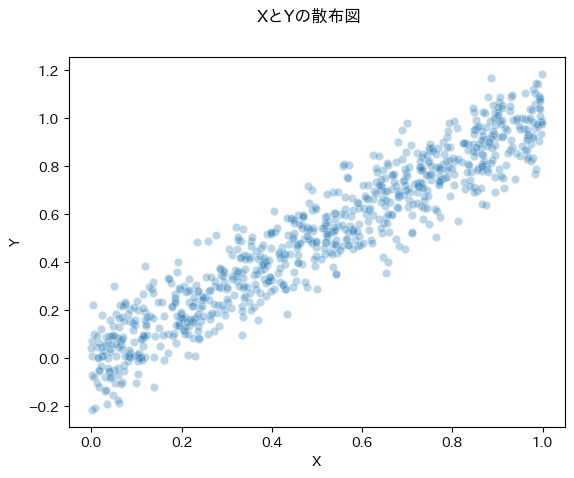

In [19]:
plot_scatter(X_train[:, 0], y_train, title = "XとYの散布図")## 明らかな線形の関係が見られる

In [20]:
from sklearn.linear_model import LinearRegression
from mli.metrics import regression_metrics

lm = LinearRegression().fit(X_train, y_train)

regression_metrics(lm, X_test, y_test)

,RMSE,R2
0,0.102286,0.889858


In [21]:
from mli.utility import get_coef

df_coef = get_coef(lm, ["X"])
df_coef.T


,intercept,X
coef,-0.010319,1.025086


##### 4.2.2 シミュレーション2：非線形の場合

$$
Y = 10sin(X_{0}) + X_{1} + \varepsilon,\\
X_{0} \sim Uniform(-2\pi, 2\pi)\\
X_{1} \sim Uniform(-2\pi, 2\pi)\\
\varepsilon \sim Normal(0, 0.01)\\
$$

- $X_{0}$と$Y$の間には非線形な関係がある。

In [22]:
def generate_simulation_data2():
    """シミュレーション2のデータを生成"""

    N = 1000
    X = np.random.uniform(-np.pi*2, np.pi*2, [N, 2])# X_{0}とX_{1}は同じ分布に従うので、行列としてまとめてサンプリングしている？
    epsilon = np.random.normal(0, 0.1, N)

    y = 10 * np.sin(X[:, 0]) + X[:, 1] + epsilon

    return train_test_split(X, y, test_size = 0.2, random_state = 42)


In [23]:
X_train, X_test, y_train, y_test = generate_simulation_data2()

In [26]:
def plot_scatters(X, y, var_names, title = None):
    """目的変数と特徴量の散布図を作成"""

    J = X.shape[1]
    fig, axes = plt.subplots(nrows = 1, ncols = J, figsize = (4 * J, 4))

    for j, ax in enumerate(axes):
        sns.scatterplot(x = X[:, j], y = y, alpha = 0.3, ax = ax)
        ax.set(
            xlabel = var_names[j],
            ylabel = "Y",
            xlim = (X.min() * 1.1, X.max() * 1.1)
        )
    fig.suptitle(title)

    fig.show()

/var/folders/2b/gxdp9fvj60s6j5jv0wtqz9br0000gn/T/ipykernel_62980/2397900613.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


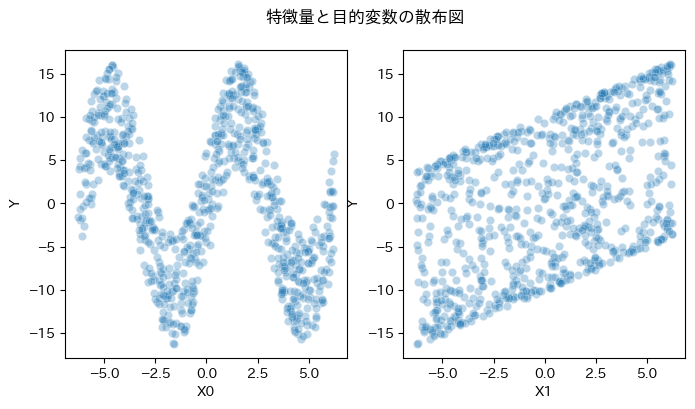

In [27]:
plot_scatters(X_train, y_train, var_names = ["X0", "X1"], title = "特徴量と目的変数の散布図")

In [28]:
## モデルの学習

lm = LinearRegression().fit(X_train, y_train)

regression_metrics(lm, X_test, y_test)

,RMSE,R2
0,6.52485,0.29938


In [36]:
### 番外編
### polynomial regressionにしてみる

from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree = 3)
x_poly3 = polynomial_features.fit_transform(X_train)
poly3_reg = LinearRegression().fit(x_poly3, y_train)
x_test_poly3 = polynomial_features.fit_transform(X_test)
y_pred = poly3_reg.predict(x_test_poly3)


In [37]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 6.081298248680745
R2: 0.391396864912529


In [40]:
x_poly3.shape

(800, 10)

- 結局、3次の多項式モデルでもfitはそれほど良くならなかった。シミュレーションデータの構造に対して、パラメトリックに3次多項式をフィッティングしているだけなので、RMSEもほとんど変わらなかった。なので、ここにおいてノンパラメトリックにデータの構造を柔軟にとらえられる機械学習モデルを用いる動機が生まれる。

In [41]:
### Random Forestを用いた予測モデルの構築

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs = -1, random_state = 42).fit(X_train, y_train)

regression_metrics(rf, X_test, y_test)


,RMSE,R2
0,0.66905,0.992634


- RandomForestが出した誤差RMSEはかなり小さく、予測性能に優れていることがわかるが、回帰のように解釈性がないことが課題。


#### 4.3 Partial Dependence

##### 4.3.1 1つのインスタンスの特徴量とモデルの予測値の関係


In [42]:
# インスタンスを取り出す

i = 0
Xi = X_test[[i]]
Xi

array([[-3.38716708, -0.56781201]])

In [43]:
# インスタンス0に対する予測値

print(f"(X0, X1) = (-3.38716708, -0.56781201)のときの予測値: {rf.predict(Xi)[0]:.2f}")

(X0, X1) = (-3.38716708, -0.56781201)のときの予測値: 1.50


ここで、「もしインスタンス0の特徴量$X_{0}$の値が-3.39ではなく、-4だったら」モデルはどんな予測値を出力していたか、を考える。_ceteris paribus_

In [46]:
def counterfactual_prediction(
    estimator, X, idx_to_replace, value_to_replace
):
    """ある特徴量の値を置き換えた時の予測値を求める

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        idx_to_replace: 値を置き換える特徴量のインデックス
        value_to_replace: 置き換える値
    """
    # バックアップ

    X_replaced = X.copy()
    X_replaced[:, idx_to_replace] = value_to_replace
    y_pred = estimator.predict(X_replaced)# 特徴量の値を置き換えた時の予測値を出力

    return y_pred



In [47]:
cp = counterfactual_prediction(estimator=rf, X = Xi,
idx_to_replace = 0, value_to_replace = -4)[0]

In [49]:
cp

6.600623698112694

In [50]:
cp = counterfactual_prediction(rf, Xi, 0, -3)[0]
print(f"(X0, X1) = (-3, -0.567)の時の予測値：{cp:.2f}")

(X0, X1) = (-3, -0.567)の時の予測値：-1.58


In [51]:
## X0の値をシミュレーション上でとりうる最小値から最大値まで変化させた時の予測値の変化を見る

X0_range = np.linspace(-np.pi*2, np.pi*2, num = 50)

cps = np.concatenate(
    [counterfactual_prediction(rf, Xi, 0, x) for x in X0_range]
)
cps


array([  1.0523377 ,   1.7640808 ,   4.27317631,   6.7102188 ,
         7.66728941,   8.48943805,   8.59428637,   8.14163359,
         7.43765823,   6.6161579 ,   2.95389586,   2.15924347,
        -0.38941848,  -2.13085281,  -6.22707515,  -7.54412485,
        -8.82784143,  -9.60490158,  -9.99088422,  -9.88982892,
        -9.62094494,  -8.56520287,  -7.22425949,  -4.78920766,
        -2.34699053,   0.79232322,   3.21304199,   5.65321618,
         7.38542469,   8.61633711,   8.66670994,   8.70776415,
         8.55431034,   7.98176846,   5.45380094,   2.85280625,
         1.32962749,  -2.09883499,  -3.37186963,  -6.30952415,
        -7.55378368,  -9.47916094, -10.23269862, -10.300544  ,
       -10.07022943,  -9.24569862,  -8.12816717,  -5.38720631,
        -3.52440854,  -2.92033408])

##### 4.3.2 すべてのインスタンスに対する特徴量と予測値の平均的な関係

In [53]:
def plot_line(x, y, xlabel = "X", ylabel = "Y", title = None):
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set(xlabel = xlabel, ylabel =ylabel)
    fig.suptitle(title)
    
    fig.show()


/var/folders/2b/gxdp9fvj60s6j5jv0wtqz9br0000gn/T/ipykernel_62980/2234068814.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


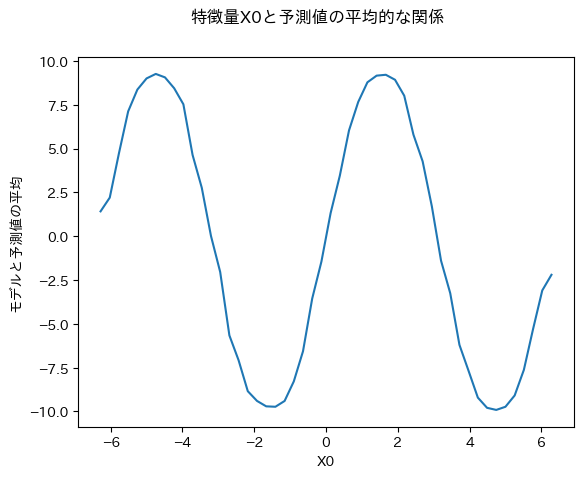

In [54]:

avg_cps = np.array(
    [counterfactual_prediction(rf, X_test, 0, x).mean() for x in X0_range]
)

plot_line(
    X0_range,
    avg_cps,
    "X0",
    "モデルと予測値の平均",
    "特徴量X0と予測値の平均的な関係"
)

このように、「他の特徴量を固定して興味のある特徴量だけを動かし、各インスタンスの予測値を平均して可視化する」解釈手法のことを **Partial Dependence(PD)** という。

In [57]:
@dataclass
class PartialDependence:
    """Partial Dependence(PD)

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        var_names: 特徴量の名前
    """

    estimator: Any
    X: np.ndarray
    var_names: list[str]

    def _counterfactual_prediction(
        self, 
        idx_to_replace: int,#注目する特徴量のインデックス
        value_to_replace: float
    ) -> np.ndarray:
        """ある特徴量の値を置き換えた時の予測値を求める

        Args:
            idx_to_replace: 値を置き換える特徴量のインデックス
            value_to_replace: 置き換える値
        """

        X_replaced = self.X.copy()
        X_replaced[:, idx_to_replace] = value_to_replace
        y_pred = self.estimator.predict(X_replaced)

        return y_pred


    def partial_dependence(
        self, 
        var_name: str,
        n_grid: int = 50
    ) -> None:
        """PDを求める

        Args: 
            var_name:
                PDを計算したい特徴量の名前
            n_grid:
                グリッドを何分割するか
                細かすぎると値が荒れるが、荒すぎると関係をうまく捉えられない
        """

        self.target_var_name = var_name

        var_index = self.var_names.index(var_name)

        value_range = np.linspace(
            self.X[:, var_index].min(),
            self.X[:, var_index].max(),
            num = n_grid
        )

        # 特徴量の値をxで変化させたときの、全てのインスタンスの予測値を平均してarrayに格納

        average_prediction = np.array(
            [self._counterfactual_prediction(var_index, x).mean() for x in value_range]
        )

        self.df_partial_dependence = pd.DataFrame(
            data = {var_name: value_range, "avg_pred": average_prediction}
        )

    def plot(self, ylim: list[float] | None = None) -> None:
        """PDを可視化

        Args:
            ylim:
                Y軸の範囲
                特に指定しなければavg_predictionの範囲にする
                異なる特徴量のPDを比較したい時などに指定する

        """

        fig, ax = plt.subplots()
        ax.plot(
            self.df_partial_dependence[self.target_var_name],
            self.df_partial_dependence["avg_pred"]
        )
        ax.set(
            xlabel = self.target_var_name,
            ylabel = "Average Prediction",
            ylim = ylim
        )
        fig.suptitle(f"Partial Dependence Plot ({self.target_var_name})")

        fig.show()

In [59]:
# インスタンスを作成
pdp = PartialDependence(rf, X_test, var_names=["X0", "X1"])

pdp.partial_dependence(var_name="X1", n_grid=50)



/var/folders/2b/gxdp9fvj60s6j5jv0wtqz9br0000gn/T/ipykernel_62980/2093792398.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


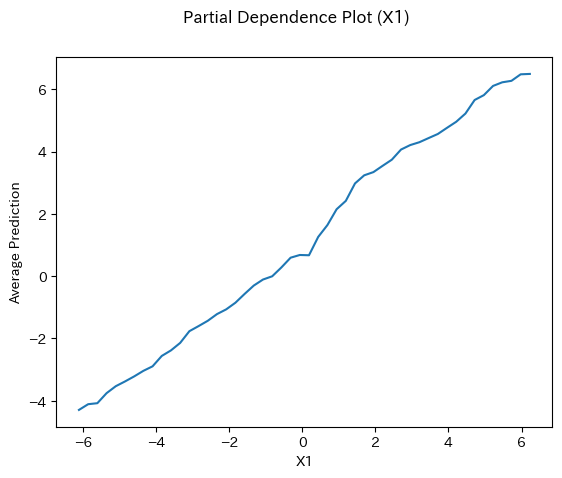

In [60]:
pdp.plot()

#### 4.5 実データを用いた分析

In [62]:
import joblib
X_train, X_test, y_train, y_test = joblib.load("/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/data/boston_housing.pkl")
rf = joblib.load("/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/model/boston_housing_rf.pkl")


/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [73]:
X_test.columns.get_loc("RM")

5

AttributeError: 'numpy.ndarray' object has no attribute 'get'

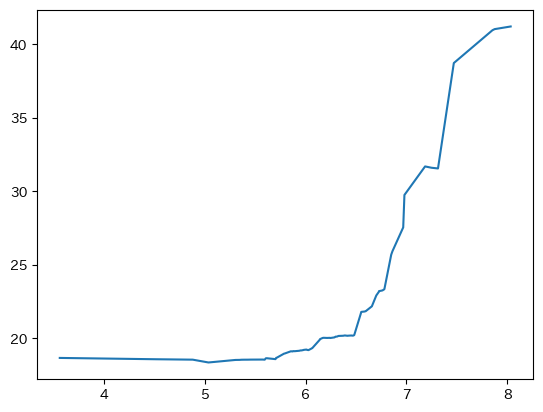

In [84]:
from sklearn.inspection import partial_dependence

pdp = partial_dependence(
    estimator = rf, 
    X = X_test,
    features = ["RM"],
    kind = "average"    
)
pdp

from sklearn.inspection import PartialDependenceDisplay

display = PartialDependenceDisplay(
    [pdp], features = ["RM"], feature_names = "RM", target_idx = 0, 
    deciles = np.linspace(X_test["RM"].min(), X_test["RM"].max(), num = 50)
)

display.plot()
plt.show()

In [113]:
X_test.columns.values

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype=object)

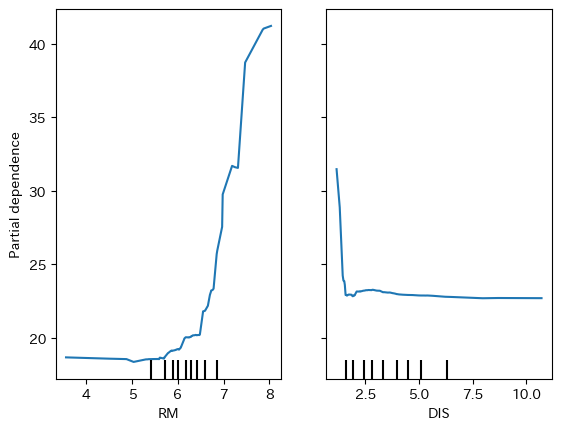

In [115]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf, X_test, features = [5,7])


/var/folders/2b/gxdp9fvj60s6j5jv0wtqz9br0000gn/T/ipykernel_62980/2596616623.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


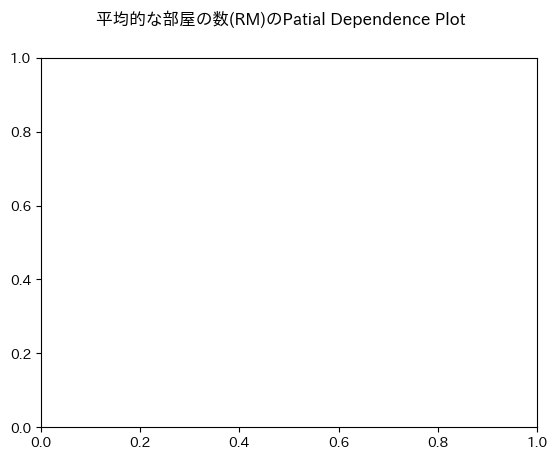

In [94]:
from sklearn.inspection import PartialDependenceDisplay

def plot_boston_pd(var_name, var_name_jp):
    """pdを可視化する関数"""
    
    pdp = partial_dependence(
        rf, X = X_test, features = var_name, kind = "average"
    )
    fig, ax = plt.subplots()
    PartialDependenceDisplay(
        [pdp], features = var_name, feature_names = var_name, target_idx = 0, 
        deciles = np.linspace(X_test[var_name].min(), X_test[var_name].max(), num = 50))
    fig.suptitle(f"{var_name_jp}({var_name})のPatial Dependence Plot")
    fig.show()

plot_boston_pd(var_name= "RM", var_name_jp="平均的な部屋の数")